In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib ipympl
import rowan
from scipy.spatial.transform import Rotation as R
from scipy import integrate
import sys
sys.path.append("../")
from utils import calc_quat_angle_error_single, calc_rel_orientation

## Prepare COLMAP, IMU and Frame files

In [14]:
aligned_colmap_image_file = 'C:/Users/tansi/Documents/Imperial_College_London/Year3/FYP_Project/aligned_campus_v3/images.txt'
colmap_image_file = 'C:/Users/tansi/Documents/Imperial_College_London/Year3/FYP_Project/campus_colmap_v3/sparse/0/images.txt'
motion_arh_data_file = './data/2022-06-20T22-00-37/MotARH.txt'
motion_att_data_file = './data/2022-06-20T22-00-37/Motion.txt'
frames_data_file = './data/2022-06-20T22-00-37/Frames.txt'
arkit_data_file = './data/2022-06-20T22-00-37/ARposes.txt'

test_aligned_colmap_image_file = 'C:/Users/tansi/Documents/Imperial_College_London/Year3/FYP_Project/aligned_campus_v3_test/images.txt'
test_motion_arh_data_file = './data/2022-06-20T22-00-18/MotARH.txt'
test_motion_att_data_file = './data/2022-06-20T22-00-18/Motion.txt'
test_frames_data_file = './data/2022-06-20T22-00-18/Frames.txt'
test_arkit_data_file = './data/2022-06-20T22-00-18/ARposes.txt'

In [3]:
frames_df = pd.read_csv(frames_data_file, sep = ",",header=None)
frames_df.columns = ['time','frameNumber','focalLenghtX','focalLenghtY','principalPointX','principalPointY']
frames_df.head()

,time,frameNumber,focalLenghtX,focalLenghtY,principalPointX,principalPointY
0,1.655759e+09,0,1599.840454,1599.840454,952.470032,682.698975
1,1.655759e+09,1,1600.466675,1600.466675,952.517700,682.679932
2,1.655759e+09,2,1600.466675,1600.466675,952.508362,682.663574
3,1.655759e+09,3,1600.466675,1600.466675,952.463928,682.676147
4,1.655759e+09,4,1600.466675,1600.466675,952.494080,682.689453


In [4]:
motion_arh_df = pd.read_csv(motion_arh_data_file, sep = ",",header=None)
motion_arh_df.columns = ['time','ang_vel_x','ang_vel_y','ang_vel_z',
                 'gravity_x','gravity_y','gravity_z',
                 'imu_acc_x','imu_acc_y','imu_acc_z', 'motionHeading']
motion_arh_df.head()

,time,ang_vel_x,ang_vel_y,ang_vel_z,gravity_x,gravity_y,gravity_z,imu_acc_x,imu_acc_y,imu_acc_z,motionHeading
0,1.655759e+09,-0.001620,0.034770,-0.001186,-0.984091,-0.000852,-0.177664,0.000723,-0.006732,-0.012186,88.449158
1,1.655759e+09,-0.001236,0.033399,0.001546,-0.984025,-0.000872,-0.178029,0.000810,-0.006849,-0.015209,88.450203
2,1.655759e+09,-0.001398,0.023617,0.001177,-0.983970,-0.000886,-0.178330,0.000786,-0.008102,-0.014023,88.450981
3,1.655759e+09,-0.001390,0.000078,-0.000673,-0.983948,-0.000899,-0.178450,0.000993,-0.007706,-0.016206,88.452469
4,1.655759e+09,-0.002168,0.011429,0.001109,-0.983938,-0.000914,-0.178507,0.001898,-0.008455,-0.023214,88.454216


<AxesSubplot:>

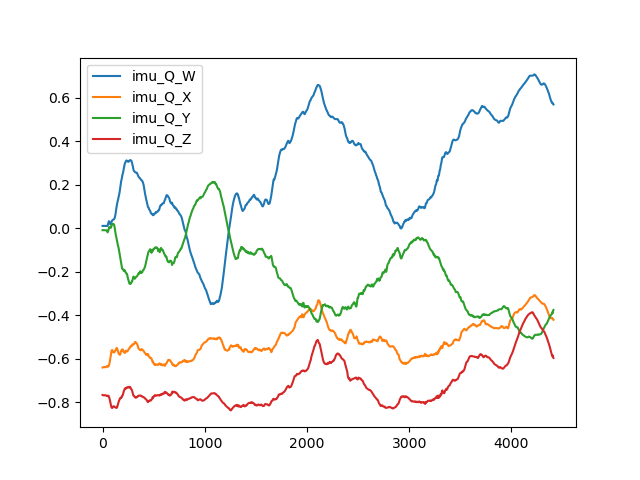

In [5]:
orientation = pd.read_csv(motion_att_data_file, sep = ",",header=None)
orientation.columns = ['time','imu_Q_W', 'imu_Q_X', 'imu_Q_Y', 'imu_Q_Z']
orientation[['imu_Q_W', 'imu_Q_X', 'imu_Q_Y', 'imu_Q_Z']].plot()

In [6]:
frames_df["imu_acc_x"] = np.interp(frames_df["time"], motion_arh_df["time"], motion_arh_df["imu_acc_x"])
frames_df["imu_acc_y"] = np.interp(frames_df["time"], motion_arh_df["time"], motion_arh_df["imu_acc_y"])
frames_df["imu_acc_z"] = np.interp(frames_df["time"], motion_arh_df["time"], motion_arh_df["imu_acc_z"])
frames_df["ang_vel_x"] = np.interp(frames_df["time"], motion_arh_df["time"], motion_arh_df["ang_vel_x"])
frames_df["ang_vel_y"] = np.interp(frames_df["time"], motion_arh_df["time"], motion_arh_df["ang_vel_y"])
frames_df["ang_vel_z"] = np.interp(frames_df["time"], motion_arh_df["time"], motion_arh_df["ang_vel_z"])
frames_df["imu_Q_W"] = np.interp(frames_df["time"], orientation["time"], orientation["imu_Q_W"])
frames_df["imu_Q_X"] = np.interp(frames_df["time"], orientation["time"], orientation["imu_Q_X"])
frames_df["imu_Q_Y"] = np.interp(frames_df["time"], orientation["time"], orientation["imu_Q_Y"])
frames_df["imu_Q_Z"] = np.interp(frames_df["time"], orientation["time"], orientation["imu_Q_Z"])

<AxesSubplot:>

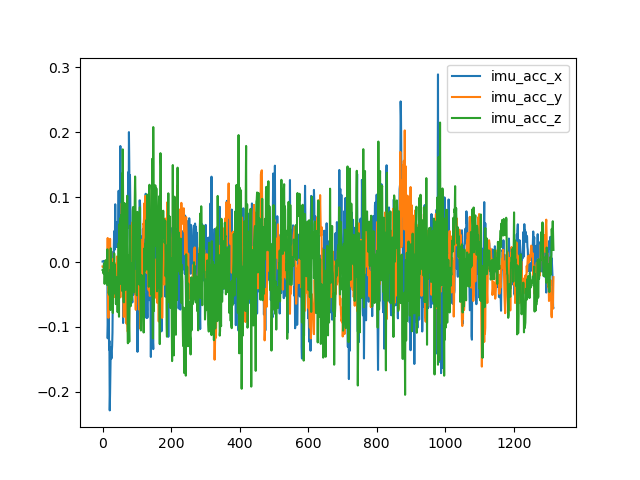

In [7]:
frames_df[["imu_acc_x", "imu_acc_y", "imu_acc_z"]].plot()

In [8]:
def convert_body_to_world(body_acc, world_orientation):
    """Converting linear acceleration in body frame to world frame"""
    r = R.from_quat(world_orientation)
    world_acc = r.apply(body_acc)
    return world_acc
frames_df["imu_acc_x_global"]  = frames_df.apply(lambda row :  convert_body_to_world(
                                        np.array(row[['imu_acc_x', 'imu_acc_y', 'imu_acc_z']]),
                                        np.array(row[['imu_Q_X', 'imu_Q_Y', 'imu_Q_Z', 'imu_Q_W', ]]))[0], axis = 1)
frames_df["imu_acc_y_global"]  = frames_df.apply(lambda row :  convert_body_to_world(
                                        np.array(row[['imu_acc_x', 'imu_acc_y', 'imu_acc_z']]),
                                        np.array(row[['imu_Q_X', 'imu_Q_Y', 'imu_Q_Z', 'imu_Q_W', ]]))[1], axis = 1)
frames_df["imu_acc_z_global"]  = frames_df.apply(lambda row :  convert_body_to_world(
                                        np.array(row[['imu_acc_x', 'imu_acc_y', 'imu_acc_z']]),
                                        np.array(row[['imu_Q_X', 'imu_Q_Y', 'imu_Q_Z', 'imu_Q_W', ]]))[2], axis = 1)
frames_df["ang_vel_x_global"]  = frames_df.apply(lambda row :  convert_body_to_world(
                                        np.array(row[['ang_vel_x', 'ang_vel_y', 'ang_vel_z']]),
                                        np.array(row[['imu_Q_X', 'imu_Q_Y', 'imu_Q_Z', 'imu_Q_W', ]]))[0], axis = 1)
frames_df["ang_vel_y_global"]  = frames_df.apply(lambda row :  convert_body_to_world(
                                        np.array(row[['ang_vel_x', 'ang_vel_y', 'ang_vel_z']]),
                                        np.array(row[['imu_Q_X', 'imu_Q_Y', 'imu_Q_Z', 'imu_Q_W', ]]))[1], axis = 1)
frames_df["ang_vel_z_global"]  = frames_df.apply(lambda row :  convert_body_to_world(
                                        np.array(row[['ang_vel_x', 'ang_vel_y', 'ang_vel_z']]),
                                        np.array(row[['imu_Q_X', 'imu_Q_Y', 'imu_Q_Z', 'imu_Q_W', ]]))[2], axis = 1)

In [9]:
from scipy import signal
frames_df["seconds"] = frames_df["time"] - frames_df["time"][0]
frames_df["timestep"] = frames_df["time"] - frames_df["time"].shift(1)
frames_df["lin_vel_x"] = integrate.cumtrapz(frames_df["imu_acc_x_global"]*-9.81, frames_df["seconds"], initial=0)
frames_df["lin_vel_y"] = integrate.cumtrapz(frames_df["imu_acc_y_global"]*-9.81, frames_df["seconds"], initial=0)
frames_df["lin_vel_z"] = integrate.cumtrapz(frames_df["imu_acc_z_global"]*-9.81, frames_df["seconds"], initial=0)
frames_df["lin_vel_x"] = signal.detrend(frames_df["lin_vel_x"])
frames_df["lin_vel_y"] = signal.detrend(frames_df["lin_vel_y"])
frames_df["lin_vel_z"] = signal.detrend(frames_df["lin_vel_z"])
frames_df["prev_lin_vel_x"] = frames_df["lin_vel_x"].shift(1)
frames_df["prev_lin_vel_y"] = frames_df["lin_vel_y"].shift(1)
frames_df["prev_lin_vel_z"] = frames_df["lin_vel_z"].shift(1)
frames_df["prev_imu_acc_x"] = frames_df["imu_acc_x"].shift(1)
frames_df["prev_imu_acc_y"] = frames_df["imu_acc_y"].shift(1)
frames_df["prev_imu_acc_z"] = frames_df["imu_acc_z"].shift(1)

In [10]:
camera_poses = pd.DataFrame()

with open(aligned_colmap_image_file, "r") as f:
    for line in f.readlines()[4::2]:
        values = line.strip('\n').split(" ")
        name = values[-1]
        q_w, q_x, q_y, q_z = values[1:5]
        r = R.from_quat(np.hstack([float(q_x), float(q_y), float(q_z), float(q_w)]))
        inv_r = r.inv()
        t_x, t_y, t_z = values[5:8]
        t_x, t_y, t_z = float(t_x), float(t_y), float(t_z)
        x, y, z = -inv_r.apply(np.hstack([t_x, t_y, t_z]))
        q_x_invert, q_y_invert, q_z_invert, q_w_invert = inv_r.as_quat()
        camera_poses = pd.concat([camera_poses, 
                                  pd.DataFrame.from_records([{'ImageFile': name, 
                                                              'POS_X': x,
                                                              'POS_Y': y,
                                                              'POS_Z': z, 
                                                              'Q_W': q_w_invert,
                                                              'Q_X': q_x_invert,
                                                              'Q_Y': q_y_invert,
                                                              'Q_Z': q_z_invert}])], ignore_index=True)
camera_poses["idx"] = camera_poses.apply(lambda row: int(row["ImageFile"].split(".")[0][6:]), axis = 1)
camera_poses.sort_values(by="idx", inplace= True)
camera_poses.reset_index(drop=True, inplace=True)

<AxesSubplot:>

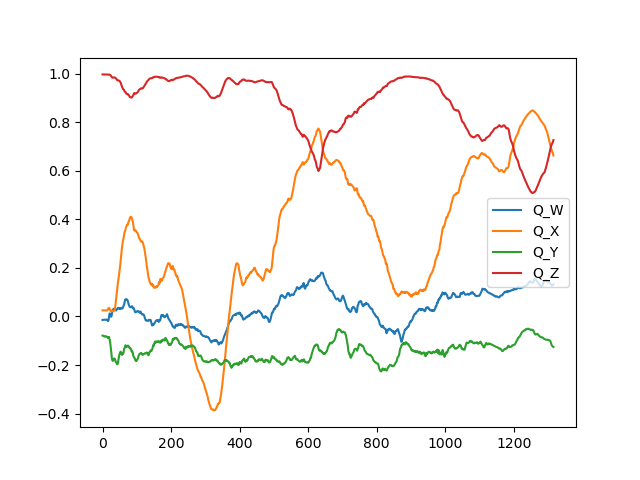

In [11]:
camera_poses.Q_W = camera_poses.Q_W.astype(float)
camera_poses.Q_X = camera_poses.Q_X.astype(float)
camera_poses.Q_Y = camera_poses.Q_Y.astype(float)
camera_poses.Q_Z = camera_poses.Q_Z.astype(float)
camera_poses[["Q_W", "Q_X", "Q_Y", "Q_Z"]].plot()

In [15]:
test_camera_poses = pd.DataFrame()

with open(test_aligned_colmap_image_file, "r") as f:
    for line in f.readlines()[4::2]:
        values = line.strip('\n').split(" ")
        name = values[-1]
        q_w, q_x, q_y, q_z = values[1:5]
        r = R.from_quat(np.hstack([float(q_x), float(q_y), float(q_z), float(q_w)]))
        inv_r = r.inv()
        t_x, t_y, t_z = values[5:8]
        t_x, t_y, t_z = float(t_x), float(t_y), float(t_z)
        x, y, z = -inv_r.apply(np.hstack([t_x, t_y, t_z]))
        q_x_invert, q_y_invert, q_z_invert, q_w_invert = inv_r.as_quat()
        test_camera_poses = pd.concat([test_camera_poses, 
                                  pd.DataFrame.from_records([{'ImageFile': name, 
                                                              'POS_X': x,
                                                              'POS_Y': y,
                                                              'POS_Z': z, 
                                                              'Q_W': q_w_invert,
                                                              'Q_X': q_x_invert,
                                                              'Q_Y': q_y_invert,
                                                              'Q_Z': q_z_invert}])], ignore_index=True)
test_camera_poses["idx"] = test_camera_poses.apply(lambda row: int(row["ImageFile"].split(".")[0][6:]), axis = 1)
test_camera_poses.sort_values(by="idx", inplace= True)
test_camera_poses.reset_index(drop=True, inplace=True)

## Check alignment

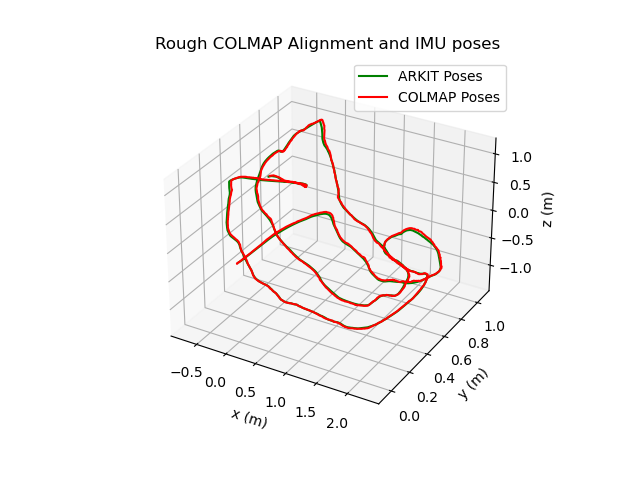

In [12]:
arkit = pd.read_csv(arkit_data_file, sep = ",",header=None)
arkit.columns = ['time', 'POS_X', 'POS_Y', 'POS_Z', 'Q_W', 'Q_X', 'Q_Y', 'Q_Z']
plt.figure()
ax = plt.axes(projection= '3d')
start = 0
end = -1
# +ve x is right, +ve y is up, +ve z is back
ax.plot3D(arkit["POS_X"][start:end], arkit["POS_Y"][start:end], arkit["POS_Z"][start:end], label = "ARKIT Poses", color = 'green')
ax.plot3D(camera_poses["POS_X"][start:end], camera_poses["POS_Y"][start:end], camera_poses["POS_Z"][start:end], label = "COLMAP Poses", color = 'red')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
ax.set_title("Rough COLMAP Alignment and IMU poses")
ax.legend()
plt.show()

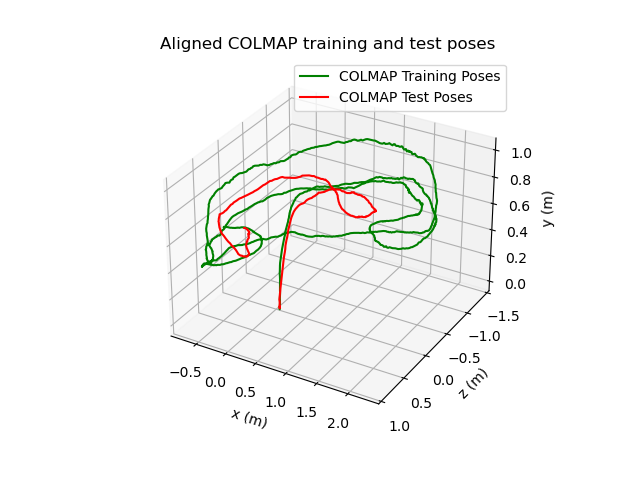

In [16]:
%matplotlib ipympl
plt.figure()
ax = plt.axes(projection= '3d')
start = 0
end = -1
# +ve x is right, +ve y is up, +ve z is south
ax.plot3D(camera_poses["POS_X"][start:end], camera_poses["POS_Z"][start:end], camera_poses["POS_Y"][start:end], label = "COLMAP Training Poses", color = 'green')
ax.plot3D(test_camera_poses["POS_X"][start:end], test_camera_poses["POS_Z"][start:end], test_camera_poses["POS_Y"][start:end], label = "COLMAP Test Poses", color = 'red')
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_ylim([1.0, -1.5])
ax.set_zlabel("y (m)")
ax.set_title("Aligned COLMAP training and test poses")
ax.legend()
plt.show()

<AxesSubplot:>

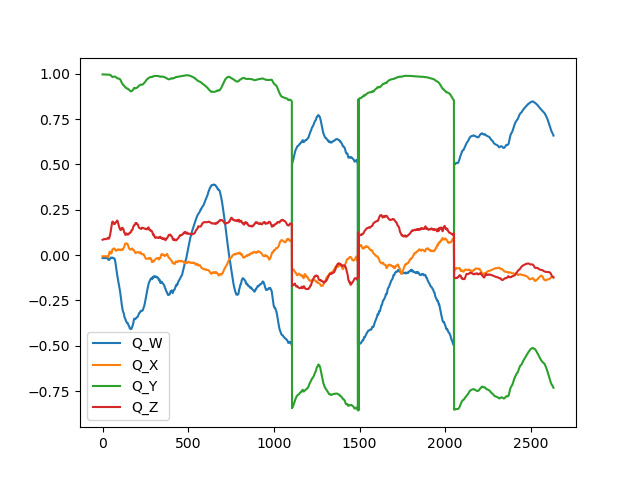

In [17]:
arkit[["Q_W","Q_X", "Q_Y", "Q_Z"]].plot()

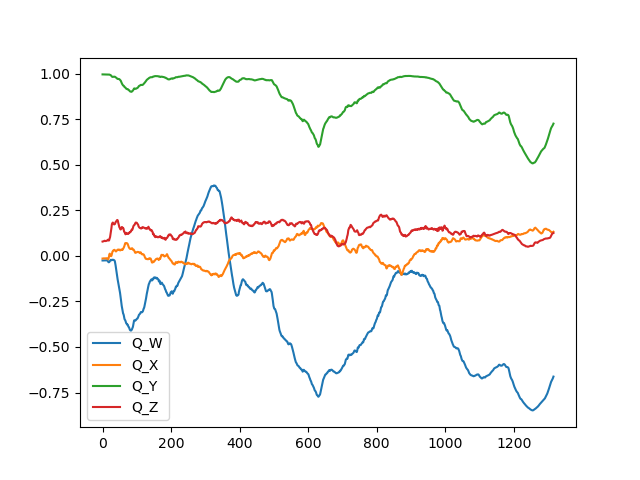

In [18]:
temp = pd.DataFrame()
# temp["Q_X"] = -camera_poses["Q_W"]
# temp["Q_Y"] = -camera_poses["Q_Z"]
# temp["Q_Z"] = camera_poses["Q_Y"]
# temp["Q_W"] = camera_poses["Q_X"]
# temp[["Q_W","Q_X", "Q_Y", "Q_Z"]].plot()
# if train:
#     temp["Q_X"] = camera_poses["Q_Z"]
#     temp["Q_Y"] = -camera_poses["Q_W"]
#     temp["Q_Z"] = -camera_poses["Q_Y"]
#     temp["Q_W"] = -camera_poses["Q_X"]
# else:
temp["Q_X"] = camera_poses["Q_W"]
temp["Q_Y"] = camera_poses["Q_Z"]
temp["Q_Z"] = -camera_poses["Q_Y"]
temp["Q_W"] = -camera_poses["Q_X"]
temp[["Q_W","Q_X", "Q_Y", "Q_Z"]].plot()

camera_poses["Q_X"] = temp["Q_X"]
camera_poses["Q_Y"] = temp["Q_Y"]
camera_poses["Q_Z"] = temp["Q_Z"]
camera_poses["Q_W"] = temp["Q_W"]



## Inject noise

In [19]:
np.random.seed(123)
mode = 1

In [20]:
if mode == 0:
    noise_x = 0
    noise_y = 0
    noise_z = 0
elif mode == 1:
    noise_x = np.random.normal(0,0.1,len(camera_poses))
    noise_y = np.random.normal(0,0.05,len(camera_poses))
    noise_z = np.random.normal(0,0.1,len(camera_poses))
camera_poses["noisy_POS_X"] = noise_x + camera_poses["POS_X"]
camera_poses["noisy_POS_Y"] = noise_y + camera_poses["POS_Y"]
camera_poses["noisy_POS_Z"] = noise_z + camera_poses["POS_Z"]


In [21]:
if mode == 0:
    noise_qw = 0
    noise_qx = 0
    noise_qy = 0
    noise_qz = 0
elif mode == 1:
    noise_qw = np.random.normal(0,0.03,len(camera_poses))
    noise_qx = np.random.normal(0,0.03,len(camera_poses))
    noise_qy = np.random.normal(0,0.03,len(camera_poses))
    noise_qz = np.random.normal(0,0.03,len(camera_poses))
camera_poses["noisy_Q_W"] = noise_qw + camera_poses["Q_W"]
camera_poses["noisy_Q_X"] = noise_qx + camera_poses["Q_X"]
camera_poses["noisy_Q_Y"] = noise_qy + camera_poses["Q_Y"]
camera_poses["noisy_Q_Z"] = noise_qz + camera_poses["Q_Z"]

# Ensure that noisy quaternions is a valid rotation
normalized_q = pd.DataFrame(rowan.normalize(camera_poses[["noisy_Q_W", "noisy_Q_X", "noisy_Q_Y", "noisy_Q_Z"]]), columns=["noisy_Q_W", "noisy_Q_X", "noisy_Q_Y", "noisy_Q_Z"])
camera_poses["noisy_Q_W"] = normalized_q["noisy_Q_W"]
camera_poses["noisy_Q_X"] = normalized_q["noisy_Q_X"]
camera_poses["noisy_Q_Y"] = normalized_q["noisy_Q_Y"]
camera_poses["noisy_Q_Z"] = normalized_q["noisy_Q_Z"]

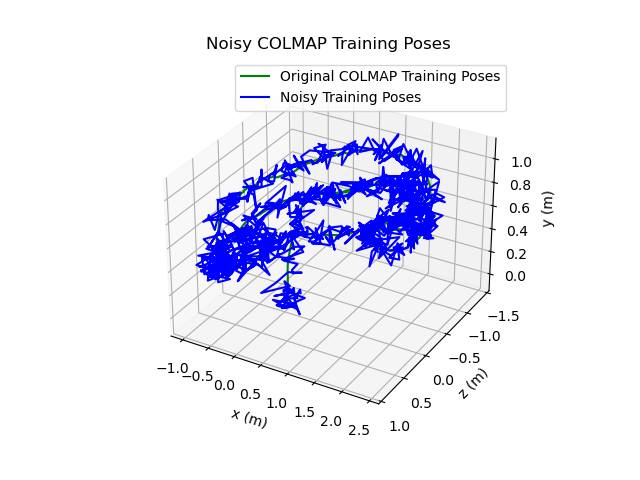

In [25]:
plt.figure()
ax = plt.axes(projection= '3d')
start = 0
end = -1
# +ve x is right, +ve y is up, +ve z is back
ax.plot3D(camera_poses["POS_X"][start:end], camera_poses["POS_Z"][start:end], camera_poses["POS_Y"][start:end], label = "Original COLMAP Training Poses", color = 'green')
ax.plot3D(camera_poses["noisy_POS_X"][start:end], camera_poses["noisy_POS_Z"][start:end], camera_poses["noisy_POS_Y"][start:end], label = "Noisy Training Poses", color = 'blue')
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_ylim([1.0, -1.5])
ax.set_zlabel("y (m)")
ax.set_title("Noisy COLMAP Training Poses")
ax.legend()
plt.show()

In [ ]:
imu_colmap_df = pd.concat([frames_df, camera_poses], axis = 1)

## Obtain IMU derived relative translation

In [ ]:
k = 15

In [ ]:
results = []
timesteps = []
for i in range(k, len(imu_colmap_df)):
    row = imu_colmap_df.iloc[i,:]
    time = row.time
    x, y, z = row.noisy_POS_X, row.noisy_POS_Y, row.noisy_POS_Z
    time_taken = 0
    imu_idx = 1
    while imu_colmap_df.iloc[i - k + imu_idx,0] < time:
        imu_row = imu_colmap_df.iloc[i - k + imu_idx,:]
        z -= imu_row.prev_lin_vel_x * imu_row.timestep + 1/2 * imu_row.prev_imu_acc_x * imu_row.timestep ** 2 
        x -= imu_row.prev_lin_vel_y * imu_row.timestep + 1/2 * imu_row.prev_imu_acc_y * imu_row.timestep ** 2 
        y += imu_row.prev_lin_vel_z * imu_row.timestep + 1/2 * imu_row.prev_imu_acc_z * imu_row.timestep ** 2
        imu_idx += 1
        time_taken += imu_row.timestep
    timesteps.append(time_taken)
    results.append([x, y, z])

imu_trans = pd.DataFrame(results, columns=["imu_POS_X", "imu_POS_Y","imu_POS_Z"])
imu_trans["idx"] = [i for i in range(k, len(imu_colmap_df))]
imu_trans.set_index("idx", inplace=True)
print(np.mean(timesteps))

In [ ]:
test_df = pd.concat([imu_colmap_df, imu_trans], axis = 1)

In [ ]:
%matplotlib inline
# test_df[["POS_X", "POS_Y","POS_Z", "noisy_POS_X", "noisy_POS_Y","noisy_POS_Z", "imu_POS_X", "imu_POS_Y","imu_POS_Z"]].plot()
test_df[["POS_X", "POS_Y","POS_Z", "imu_POS_X", "imu_POS_Y","imu_POS_Z"]].plot()

In [ ]:
# True relative translation
test_df["rel_POS_X"] = test_df["POS_X"] - test_df["POS_X"].shift(k)
test_df["rel_POS_Y"] = test_df["POS_Y"] - test_df["POS_Y"].shift(k)
test_df["rel_POS_Z"] = test_df["POS_Z"] - test_df["POS_Z"].shift(k)

# noisy relative translation
test_df["noisy_rel_POS_X"] = test_df["noisy_POS_X"] - test_df["noisy_POS_X"].shift(k)
test_df["noisy_rel_POS_Y"] = test_df["noisy_POS_Y"] - test_df["noisy_POS_Y"].shift(k)
test_df["noisy_rel_POS_Z"] = test_df["noisy_POS_Z"] - test_df["noisy_POS_Z"].shift(k)

# imu relative translation
test_df["imu_rel_POS_X"] = test_df["imu_POS_X"] - test_df["noisy_POS_X"].shift(k)
test_df["imu_rel_POS_Y"] = test_df["imu_POS_Y"] - test_df["noisy_POS_Y"].shift(k)
test_df["imu_rel_POS_Z"] = test_df["imu_POS_Z"] - test_df["noisy_POS_Z"].shift(k)

print("Just COLMAP")
err =[]
for i in range(len(test_df) - k):
    err.append(np.linalg.norm(np.array(test_df[["noisy_rel_POS_X", "noisy_rel_POS_Y","noisy_rel_POS_Z"]].iloc[k+i,:]) - np.array(test_df[["rel_POS_X", "rel_POS_Y", "rel_POS_Z"]].iloc[k + i,:])))
print(f'Translation error {np.median(err)} (median) m, {np.mean(err)} (mean) m')

print("Just IMU")
err =[]
for i in range(len(test_df) - k):
    err.append(np.linalg.norm(np.array(test_df[["imu_rel_POS_X", "imu_rel_POS_Y","imu_rel_POS_Z"]].iloc[k+i,:]) - np.array(test_df[["rel_POS_X", "rel_POS_Y", "rel_POS_Z"]].iloc[k + i,:])))
print(f'Translation error {np.median(err)} (median) m, {np.mean(err)} (mean) m')

## Obtain IMU derived absolute rotation

In [ ]:
imu_colmap_df['prev_ang_vel_x_global'] = imu_colmap_df['ang_vel_x_global'].shift(1) 
imu_colmap_df['prev_ang_vel_y_global'] = imu_colmap_df['ang_vel_y_global'].shift(1)
imu_colmap_df['prev_ang_vel_z_global'] = imu_colmap_df['ang_vel_z_global'].shift(1)

In [ ]:
abs_results = []
rel_results = []
timesteps = []
for i in range(k, len(imu_colmap_df)):
    row = imu_colmap_df.iloc[i,:]
    time = row.time
    qw = row.noisy_Q_W
    qx = row.noisy_Q_X
    qy = row.noisy_Q_Y
    qz = row.noisy_Q_Z
    q_prev = np.array([qw, qx, qy, qz])
    cur_q = q_prev
    imu_idx = 1 
    time_taken = 0
    while imu_colmap_df.iloc[i - k + imu_idx,0] < time:
        imu_row = imu_colmap_df.iloc[i - k + imu_idx,:]
        cur_q = rowan.calculus.integrate (cur_q, 
                                        np.hstack([-row["prev_ang_vel_y_global"],
                                                   row["prev_ang_vel_z_global"], 
                                                   -row["prev_ang_vel_x_global"]]),
                                        row['timestep'])
        cur_q = rowan.normalize(cur_q)
        imu_idx += 1
        time_taken += imu_row.timestep
    timesteps.append(time_taken)
    rel_q = calc_rel_orientation(q_prev, cur_q)
    abs_results.append(cur_q)
    rel_results.append(rel_q)

imu_q_ahrs = pd.DataFrame(abs_results, columns=["arkit_imu_Q_W", "arkit_imu_Q_X", "arkit_imu_Q_Y", "arkit_imu_Q_Z"])
imu_q_ahrs["idx"] = [i for i in range(k, len(imu_colmap_df))]
imu_q_ahrs.set_index("idx", inplace=True)

imu_q_ahrs_rel = pd.DataFrame(rel_results, columns=["imu_rel_Q_W", "imu_rel_Q_X", "imu_rel_Q_Y", "imu_rel_Q_Z"])
imu_q_ahrs_rel["idx"] = [i for i in range(k, len(imu_colmap_df))]
imu_q_ahrs_rel.set_index("idx", inplace=True)
print(np.mean(timesteps))

In [ ]:
results = []
for i in range(k, len(imu_colmap_df)):
    qw = imu_colmap_df.iloc[i - k, :].noisy_Q_W
    qx = imu_colmap_df.iloc[i - k, :].noisy_Q_X
    qy = imu_colmap_df.iloc[i - k, :].noisy_Q_X
    qz = imu_colmap_df.iloc[i - k, :].noisy_Q_Z
    q_prev = np.array([qw, qx, qy, qz])
    qw = imu_colmap_df.iloc[i, :].noisy_Q_W
    qx = imu_colmap_df.iloc[i, :].noisy_Q_X
    qy = imu_colmap_df.iloc[i, :].noisy_Q_X
    qz = imu_colmap_df.iloc[i, :].noisy_Q_Z
    q = np.array([qw, qx, qy, qz]) 
    
    results.append(calc_rel_orientation(q_prev, q))
noisy_orient_rel = pd.DataFrame(results, columns=["rel_Q_W", "rel_Q_X", "rel_Q_Y", "rel_Q_Z"])
noisy_orient_rel["idx"] = [i for i in range(k, len(imu_colmap_df))]
noisy_orient_rel.set_index("idx", inplace=True)

# True Relative orientation
true_rel_orientation = []
for i in range(k, len(imu_colmap_df)):
    qw = imu_colmap_df.iloc[i - k, :].Q_W
    qx = imu_colmap_df.iloc[i - k, :].Q_X
    qy = imu_colmap_df.iloc[i - k, :].Q_X
    qz = imu_colmap_df.iloc[i - k, :].Q_Z
    q_prev = np.array([qw, qx, qy, qz])
    qw = imu_colmap_df.iloc[i, :].Q_W
    qx = imu_colmap_df.iloc[i, :].Q_X
    qy = imu_colmap_df.iloc[i, :].Q_X
    qz = imu_colmap_df.iloc[i, :].Q_Z
    q = np.array([qw, qx, qy, qz]) 
    
    true_rel_orientation.append(calc_rel_orientation(q_prev, q))
true_rel = pd.DataFrame(true_rel_orientation, columns=["true_rel_Q_W", "true_rel_Q_X", "true_rel_Q_Y", "true_rel_Q_Z"])
true_rel["idx"] = [i for i in range(k, len(imu_colmap_df))]
true_rel.set_index("idx", inplace=True)

In [ ]:
print("Just COLMAP")
axis_angle_err =[]
for i in range(len(imu_q_ahrs_rel)):
    axis_angle_err.append(
        calc_quat_angle_error_single(noisy_orient_rel[["rel_Q_W", "rel_Q_X", "rel_Q_Y", "rel_Q_Z"]].iloc[i,:],
                                    true_rel[["true_rel_Q_W", "true_rel_Q_X", "true_rel_Q_Y", "true_rel_Q_Z"]].iloc[i,:])
    )
print(f'Orientation error {np.median(axis_angle_err)} (median) deg, {np.mean(axis_angle_err)} (mean) deg')

print("AHRS")
axis_angle_err =[]
for i in range(len(imu_q_ahrs_rel)):
    axis_angle_err.append(
        calc_quat_angle_error_single(imu_q_ahrs_rel[["imu_rel_Q_W", "imu_rel_Q_X", "imu_rel_Q_Y", "imu_rel_Q_Z"]].iloc[i,:],
                                    true_rel[["true_rel_Q_W", "true_rel_Q_X", "true_rel_Q_Y", "true_rel_Q_Z"]].iloc[i,:])
    )
print(f'Orientation error {np.median(axis_angle_err)} (median) deg, {np.mean(axis_angle_err)} (mean) deg')

In [ ]:
test_df = pd.concat([imu_colmap_df, imu_q_ahrs], axis = 1)
plt.figure(figsize=(10,10))
plt.plot(test_df["arkit_imu_Q_W"], label="arkit_imu_Q_W")
plt.plot(test_df["arkit_imu_Q_X"], label="arkit_imu_Q_X")
plt.plot(test_df["arkit_imu_Q_Y"], label="arkit_imu_Q_Y")
plt.plot(test_df["arkit_imu_Q_Z"], label="arkit_imu_Q_Z")
plt.plot(test_df["Q_W"], label="Q_W")
plt.plot(test_df["Q_X"], label="Q_X")
plt.plot(test_df["Q_Y"], label="Q_Y")
plt.plot(test_df["Q_Z"], label="Q_Z")
plt.legend()
plt.show()

In [ ]:
imu_colmap_df = pd.concat([imu_colmap_df[["ImageFile", "timestep", "POS_X", "POS_Y", "POS_Z", "Q_W", "Q_X", "Q_Y", "Q_Z"]], imu_trans, imu_q_ahrs], axis = 1)

## Write to file

In [ ]:
final_write_file = imu_colmap_df
final_write_file = final_write_file[["ImageFile", "timestep", 
                                     "POS_X", "POS_Y", "POS_Z", 
                                     "Q_W", "Q_X", "Q_Y", "Q_Z",
                                     "imu_POS_X", "imu_POS_Y", "imu_POS_Z", 
                                     "arkit_imu_Q_W", "arkit_imu_Q_X","arkit_imu_Q_Y","arkit_imu_Q_Z"
                                    ]]

In [ ]:
final_write_file.rename(columns={"arkit_imu_Q_W": "imu_Q_W", 
                                 "arkit_imu_Q_X": "imu_Q_X",
                                 "arkit_imu_Q_Y": "imu_Q_Y",
                                 "arkit_imu_Q_Z": "imu_Q_Z"}, inplace=True)
final_write_file.loc[0:k-1,'imu_POS_X'] = final_write_file.loc[0:k-1,'POS_X']
final_write_file.loc[0:k-1,'imu_POS_Y'] = final_write_file.loc[0:k-1,'POS_Y']
final_write_file.loc[0:k-1,'imu_POS_Z'] = final_write_file.loc[0:k-1,'POS_Z']
final_write_file.loc[0:k-1,'imu_Q_W'] = final_write_file.loc[0:k-1,'Q_W']
final_write_file.loc[0:k-1,'imu_Q_X'] = final_write_file.loc[0:k-1,'Q_X']
final_write_file.loc[0:k-1,'imu_Q_Y'] = final_write_file.loc[0:k-1,'Q_Y']
final_write_file.loc[0:k-1,'imu_Q_Z'] = final_write_file.loc[0:k-1,'Q_Z']
final_write_file.loc[0,'timestep'] = 0.0

In [ ]:
final_write_file[["POS_X", "POS_Y", "POS_Z", "imu_POS_X", "imu_POS_Y", "imu_POS_Z"]].plot()
final_write_file[["Q_W", "Q_X", "Q_Y", "Q_Z", "imu_Q_W", "imu_Q_X", "imu_Q_Y", "imu_Q_Z"]].plot()

In [ ]:
final_write_file.to_csv('D:/Imperial/FYP/captured_data/campus_v3/train/train_clean_skip_15.txt', 
                        header=True, 
                        index=None, 
                        sep=' ', 
                        mode='w')

In [ ]:
test = pd.read_csv("D:/Imperial/FYP/captured_data/campus_v3/train/train_noisy_v1.txt", sep=' ')
test[["Q_W", "Q_X", "Q_Y", "Q_Z", "imu_Q_W", "imu_Q_X", "imu_Q_Y", "imu_Q_Z"]].plot()